In [1]:
import math, random
import numpy as np
import pandas as pd
from simanneal import Annealer

In [2]:
class VaccineSiteDistributor(Annealer):
    def __init__(self, dists_matrix: np.array, ccvi_array: np.array, min_temp: float,
                 max_temp: float, init_state: tuple[list[int], list[int]], metric: int=1,
                 tract_index_map: dict[int, int]={}) -> None:
        '''
        Constructs a VaccineSiteDistributor object that corresponds to the
        specified input. For ease of use, use the from_csv_files class method instead
        '''
        self.dists_matrix = dists_matrix
        self.ccvi_array = ccvi_array
        self.Tmin = min_temp
        self.Tmax = max_temp
        if tract_index_map:
            self.tract_index_map = tract_index_map
            self.tracts = {tract for tract in tract_index_map}
        else:
            tracts = sorted(init_state[0] + init_state[1])
            self.tract_index_map = {tract: index for index, tract in enumerate(tracts)}
            self.tracts = set(tracts)

        self.num_sites = len(init_state[0])
        self.num_tracts = len(self.tracts)
        self.max_dist = np.max(self.dists_matrix)

        if metric == 1:
            self.metric = 1
        elif metric == 2:
            self.metric = 2
        elif metric == 3:
            self.metric = 3
        else:
            raise ValueError('metric must be either 1, 2, or 3')

        super(VaccineSiteDistributor, self).__init__(init_state)

        self.prior_scores = self.score_solution('monroe_vaccine_tracts_short.txt')
        self.posterior_scores = None

    def move(self) -> None:
        '''
        Takes a random step somewhere in the search space
        '''
        has_site = self.state[0].pop(random.randrange(self.num_sites))
        has_no_site = self.state[1].pop(random.randrange(self.num_tracts - self.num_sites))
        self.state[0].append(has_no_site)
        self.state[1].append(has_site)

    def energy(self) -> float:
        '''
        Returns the energy of the current state of the system
        '''
        energy, _, _, _ = self.scores(self.state)
        return energy

    def scores(self, state: tuple[list[int], list[int]]) -> tuple[float, float, np.array, np.array]:
        '''
        Calculates the total energy and average minimum distance to a vaccination
        center for the overall system at the specified state
        '''
        energies = np.zeros(self.num_tracts, dtype=np.float64)
        min_dists = np.zeros(self.num_tracts, dtype=np.float64)
        for tract1 in self.tracts:
            index1 = self.tract_index_map[tract1]
            min_dist = float('inf')
            for tract2 in state[0]:
                index2 = self.tract_index_map[tract2]
                dist = self.dists_matrix[index1, index2]
                if not math.isnan(dist) and dist < min_dist:
                    min_dist = dist

            min_dists[index1] = min_dist
            ccvi = self.ccvi_array[index1]
            if not math.isnan(ccvi):
                if self.metric == 1:
                    energies[index1] = min_dist * ccvi
                elif self.metric == 2:
                    energies[index1] = (1.0 + ccvi) ** min_dist
                elif self.metric == 3:
                    energies[index1] = min_dist / self.max_dist + ccvi

        return np.sum(energies), np.mean(min_dists), energies, min_dists

    def deltas(self) -> tuple[np.array, np.array]:
        '''
        Calculates the deltas for both energy and minimum distance to the
        nearest distribution center for all census tracts. Only works after
        annealing has completed
        '''
        self.posterior_scores = self.scores(self.best_state)
        energy_deltas = self.prior_scores[2] - self.posterior_scores[2]
        min_dist_deltas = self.prior_scores[3] - self.posterior_scores[3]
        return energy_deltas, min_dist_deltas

    def score_solution(self, sol_file: str) -> tuple[float, float, np.array, np.array]:
        '''
        Scores a preexisting solution to the distribution problem. Files should be
        of the same format as monroe_vaccine_tracts_short.txt or quantum1.txt
        '''
        have_sites = set()
        with open(sol_file) as file:
            for line in file:
                tract = int(line.strip())
                have_sites.add(tract)

        have_no_sites = set(self.tracts) - have_sites
        state = (list(have_sites), list(have_no_sites))
        return self.scores(state)

    def solution_deltas(self, sol_file: str) -> tuple[np.array, np.array]:
        '''
        Returns the deltas between the starting state of the annealer
        and the provided input solution
        '''
        scores = self.score_solution(sol_file)
        energy_deltas = self.prior_scores[2] - scores[2]
        min_dist_deltas = self.prior_scores[3] - scores[3]
        return energy_deltas, min_dist_deltas

    @classmethod
    def from_csv_files(cls, dists_file: str, stats_file: str, num_sites: int,
                       min_temp: float, max_temp: float, metric: int=1) -> 'VaccineSiteDistributor':
        '''
        Builds a VaccineSiteDistributor object from the specified CSV files and input options
        '''
        dists_matrix, tract_index_map = cls._parse_dists_file(dists_file)
        ccvi_array = cls._parse_stats_file(stats_file, len(tract_index_map))
        tracts = [tract for tract in tract_index_map]
        random.shuffle(tracts)
        init_state = (tracts[:num_sites], tracts[num_sites:])
        return cls(dists_matrix, ccvi_array, min_temp, max_temp, init_state, metric, tract_index_map)

    @staticmethod
    def _parse_dists_file(dists_file: str) -> tuple[np.array, dict[int, int]]:
        '''
        Retrieves census tract distances from a file of the same format as monroe_tract_dists.csv
        '''
        dists = pd.read_csv(dists_file)
        if ['tract1', 'mi_to_tract', 'tract2'] == list(dists):
            tract_index_map = {tract: index for index, tract in enumerate(dists['tract1'].unique())}
            shape = (len(tract_index_map),) * 2
            dists_matrix = np.zeros(shape, dtype=np.float64)
            for _, row in dists.iterrows():
                tract1, dist, tract2 = int(row[0]), row[1], int(row[2])
                index1, index2 = tract_index_map[tract1], tract_index_map[tract2]
                dists_matrix[index1, index2] = dist

            return dists_matrix, tract_index_map

        else:
            raise ValueError('dists_file must be of the form tract1,mi_to_tract,tract2')

    @staticmethod
    def _parse_stats_file(stats_file: str, num_tracts: int) -> np.array:
        '''
        Retrieves CCVI data from a file of the same format as monroe_tracts.csv
        '''
        stats = pd.read_csv(stats_file)
        if 'tract' in stats and 'ccvi' in stats:
            if len(stats['tract'].unique()) == num_tracts:
                return np.array(stats['ccvi'])

            else:
                raise ValueError('stats_file must have the same number of unique tracts as dists_file')

        else:
            raise ValueError('stats_file must be of the form ...,tract,...,ccvi,...')

In [3]:
vsd = VaccineSiteDistributor.from_csv_files('monroe_tract_dists.csv', 'monroe_tracts.csv',
                                            num_sites=65, min_temp=0.0001, max_temp=35.0, metric=1)

In [4]:
vsd.anneal()
vsd.best_energy

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00010         55.31     0.00%     0.00%     0:02:09     0:00:00

55.31208926585622

In [5]:
vsd.deltas()

(array([ 0.37455988,  0.26190266, -0.39413664,  0.22711721, -0.06261388,
         0.01991391,  0.56846498, -0.36831157,  0.3144875 , -0.32482656,
         0.        ,  0.        ,  0.27620084,  0.36004024, -0.25200261,
        -0.22453819,  0.09275424,  0.21565807,  0.26889929,  0.26361696,
         0.10319379, -0.02970814, -0.69935694, -0.46080942, -0.04784624,
         0.46175472,  0.12621285,  0.70654576,  0.48672384,  0.51497422,
         0.01626297, -0.06528806,  0.45585057, -0.25890886,  0.43739027,
        -0.63899866,  0.30741986,  0.38813372,  0.46200264, -0.45670074,
         0.09431751, -0.03110635,  0.10101484,  0.28904122,  0.40567737,
         0.19100678,  0.28365757,  0.58971666,  0.06042445,  0.45761623,
         0.66766868,  0.022613  , -0.46739311,  0.83760828,  0.23731814,
        -0.31167065, -0.50042497, -0.1744117 , -0.01745819, -0.44493031,
        -0.67887757,  0.        , -0.05708051,  0.04164976,  1.02082583,
         0.35445391,  0.81222602,  0.39617676,  0.4

Text(0.5, 1.0, 'Change in energy by CCVI using Metric 1')

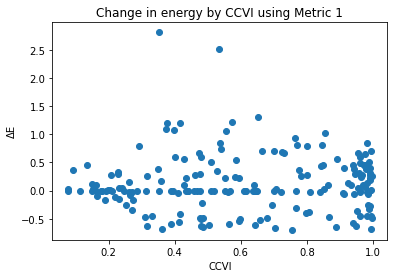

In [6]:
import matplotlib.pyplot as plt

plt.scatter(vsd.ccvi_array, vsd.deltas()[0])
plt.xlabel('CCVI')
plt.ylabel('ΔE')
plt.title('Change in energy by CCVI using Metric 1')
#plt.savefig('scatterplot_metric.png')

In [7]:
from statistics import mean, median

def get_bins(deltas: np.array, num_bins: int) -> list[list[float]]:
    bins = [[] for _ in range(num_bins)]

    for index, delta in enumerate(deltas):
        b, i, j = 0, 0, (1 / num_bins)
        binned = False
        ccvi = vsd.ccvi_array[index]
        while not binned and not math.isnan(ccvi):
            if i < ccvi < j:
                bins[b].append(delta)
                binned = True
            else:
                b, i, j = (b + 1), j, (j + 1 / num_bins)

    return bins

In [8]:
bins = get_bins(vsd.deltas()[0], 12)
means = [mean(b) for b in bins]
medians = [median(b) for b in bins]
counts = [len(b) for b in bins]
means, medians, counts

([0.013389797884470409,
  0.10674162009232832,
  0.037371866888591135,
  -0.08869888183783994,
  0.44378148568723735,
  -0.03352217142705316,
  0.4052119435443246,
  0.039881823331150944,
  0.07255461554122879,
  0.13340725812801055,
  0.1974322374575222,
  0.10926800240842474],
 [0.013389797884470409,
  0.02160885578572544,
  0.0,
  -0.05216340682736709,
  0.16341250181172384,
  0.0,
  0.23138257182419725,
  0.0,
  0.0,
  0.13180847930761005,
  0.0943175083651262,
  0.1315841397121211],
 [2, 9, 15, 14, 15, 20, 16, 17, 9, 12, 13, 48])

In [9]:
xs = np.array([str(i) for i in range(len(bins))])
ys = np.array(means)
zs = np.array(counts)
ws = np.array(medians)

Text(0.5, 1.0, 'Average change in energy by risk classification using Metric 1')

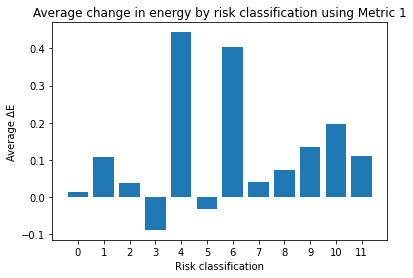

In [10]:
plt.bar(xs, means)
plt.xlabel('Risk classification')
plt.ylabel('Average ΔE')
plt.title('Average change in energy by risk classification using Metric 1')
#plt.savefig('barplot_metric1.png')